In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import yaml
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pytorch3dunet.augment.transforms import Transformer
from pytorch3dunet.datasets.utils import FilterSliceBuilder

def calculate_stats(images):
    """
    Calculates min, max, mean, std given a list of ndarrays
    """
    # flatten first since the images might not be the same size
    flat = images
    # flat = np.concatenate(
    #     [img.ravel() for img in images]
    # )
    return {'pmin': np.percentile(flat, 0.5), 'pmax': np.percentile(flat, 99.5), 'mean': np.mean(flat),
            'std': np.std(flat)}


def load_transformer(p):
    config = yaml.safe_load(open(p, 'r'))

    transform_config = config["loaders"]["train"]["transformer"]
    slice_config = config["loaders"]["train"]["slice_builder"]
    datapath = config["loaders"]["train"]["file_paths"][0]
    print("datapath", datapath)


    files = os.listdir(datapath)

    def load_case(i):
        f = h5py.File(i, "r")

        print(datapath)

        raw = f["raw"][:]
        mask = f["label"][:]
        artery = f["artery"][:]

        stats = calculate_stats(raw)
        
        transformer = Transformer(transform_config, stats)
        raw_transform = transformer.raw_transform()
        label_transform = transformer.label_transform()

        slice_builder = FilterSliceBuilder(raw, mask, None, slice_config["patch_shape"], slice_config["stride_shape"], border=slice_config["border"], threshold=slice_config["threshold"], slack_acceptance=slice_config["slack_acceptance"])

        return raw, mask, artery, raw_transform, label_transform, slice_builder

    return files, load_case

def get_aneurysm_bounds_raw(mask):
    x_s = mask.sum(axis=(1, 2))
    y_s = mask.sum(axis=(0, 2))
    z_s = mask.sum(axis=(0, 1))

    x = slice(*np.where(x_s)[0][[0, -1]])
    y = slice(*np.where(y_s)[0][[0, -1]])
    z = slice(*np.where(z_s)[0][[0, -1]])

    return x, y, z

def get_aneurysm_bounds(mask):
    x_s = mask.sum(axis=(1, 2))
    y_s = mask.sum(axis=(0, 2))
    z_s = mask.sum(axis=(0, 1))

    x = int(np.where(x_s)[0][[0, -1]].mean())
    y = int(np.where(y_s)[0][[0, -1]].mean())
    z = int(np.where(z_s)[0][[0, -1]].mean())

    return x, y, z

def mask_overlay(image, mask, color=(0., 1., 0.), weight=.8):
    """
    Helper function to visualize mask on the top of the aneurysm
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)

    image = np.dstack((image, image, image))
    weighted_sum = image * weight + mask * (1 - weight) # cv2.addWeighted(image, 1 - weight, mask, weight, 0.,  dtype=cv2.CV_32F)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]
    return img

[autoreload of pytorch3dunet.datasets.utils failed: Traceback (most recent call last):
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in up

In [11]:
case = "/media/lm/Samsung_T5/Uni/Medml/training/train/h5_size_adjusted/A003.h5.h5"

files, load_case = load_transformer("/home/lm/Schreibtisch/Uni/MedicalML/pytorch-3dunet/train-configs/philipp_config_best_2.yaml")
load_case(case)

[autoreload of pytorch3dunet.datasets.utils failed: Traceback (most recent call last):
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in up

datapath /media/lm/Samsung_T5/Uni/Medml/training/train/h5_size_adjusted
/media/lm/Samsung_T5/Uni/Medml/training/train/h5_size_adjusted


AssertionError: Height and Width must be greater or equal 64

datapath /media/lm/Samsung_T5/Uni/Medml/training/train/h5_zoomed
/media/lm/Samsung_T5/Uni/Medml/training/train/h5_zoomed/A028.h5
/media/lm/Samsung_T5/Uni/Medml/training/train/h5_zoomed
{'pmin': 0.031248481981898016, 'pmax': 0.18711934170342584, 'mean': 0.10027981330275529, 'std': 0.025826403267313662}
unique_aneus in this set [0 1]
Volume: 332 332.0 1.0 (slice(48, 112, None), slice(16, 80, None), slice(0, 64, None))
Volume: 332 332.0 1.0 (slice(48, 112, None), slice(16, 80, None), slice(16, 80, None))
Volume: 332 332.0 1.0 (slice(48, 112, None), slice(32, 96, None), slice(0, 64, None))
Volume: 332 332.0 1.0 (slice(48, 112, None), slice(32, 96, None), slice(16, 80, None))
Volume: 332 332.0 1.0 (slice(64, 128, None), slice(16, 80, None), slice(0, 64, None))
Volume: 332 332.0 1.0 (slice(64, 128, None), slice(16, 80, None), slice(16, 80, None))
Volume: 332 332.0 1.0 (slice(64, 128, None), slice(32, 96, None), slice(0, 64, None))
Volume: 332 332.0 1.0 (slice(64, 128, None), slice(32, 96, No

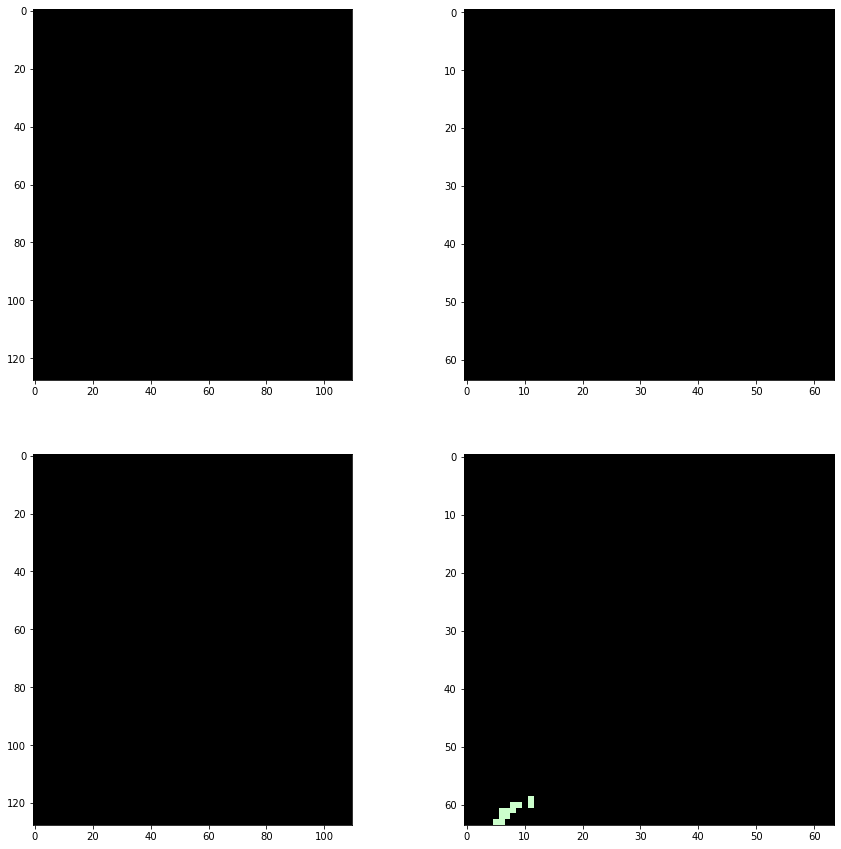

In [32]:
config_path = "../train-configs/artery_seg_test.yml"

files, load_case = load_transformer(config_path)
test_cases = np.random.choice(len(files), 8)

cmap = "Greys_r"
plt.figure(figsize=(15, 15))
for i in range(2):
    case_idx = i
    raw, label, artery, raw_transform, label_transform, artery_transform, slice_builder = load_case(test_cases[case_idx])

    x, y, z = get_aneurysm_bounds(label)
    bound = get_aneurysm_bounds_raw(label)

    artery_t = artery_transform(artery)
    raw_t = np.squeeze(raw_transform(raw, artery=artery_t))
    label_t = np.squeeze(label_transform(label))
    artery_t = np.squeeze(artery_t)

    bounds = slice_builder.raw_slices[0]

    print(bounds, raw_t.shape)
    artery_t = raw_t[1][bounds]
    raw_t = raw_t[0][bounds]
    label_t = label_t[bounds]


    start = i * 2
    show_mask = True

    #x, y, z = get_aneurysm_bounds(label_t)
    x = raw_t.shape[0] // 2


    plt.subplot(2, 2, start + 1)
    plt.imshow(mask_overlay(artery[x], artery[x]) if show_mask else raw[x], cmap=cmap)

    plt.subplot(2, 2, start + 2)
    plt.imshow(mask_overlay(artery_t[x], artery_t[x]) if show_mask else raw_t[x], cmap=cmap)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from ipywidgets import widgets
%matplotlib widget

def mask_overlay(image, mask, color=(0., 1., 0.), weight=.8):
    """
    Helper function to visualize mask on the top of the aneurysm
    """
    mask = np.dstack((mask, mask, mask)) * np.array(color)
    mask = mask.astype(np.uint8)
    weighted_sum = image * weight + mask * (1 - weight) # cv2.addWeighted(image, 1 - weight, mask, weight, 0.,  dtype=cv2.CV_32F)
    img = image.copy()
    ind = mask[:, :, 1] > 0
    img[ind] = weighted_sum[ind]
    return img


class ImageSlicer(object):

    def __init__(self, ax, img, mask, start_index):
        self.ax = ax

        # convert to numpy array
        self.image_np = img
        self.mask_np = mask

        # get number of slices
        _, _, self.slices = self.image_np.shape
        self.ind = start_index if start_index is not None else self.slices // 2
        self.show_mask = True

        # plot image with mask overlay
        self.image_plt = self.ax.imshow(self.overlay)
        self._draw()

    @property
    def overlay(self):
        # get image and mask slice
        image = self.image_np[:, :, self.ind]
        image = image / np.max(image)
        image = np.dstack((image, image, image))
        mask = self.mask_np[:, :, self.ind]

        # create masked overlay
        if self.show_mask:
            return mask_overlay(image, mask)
        else: 
            return image

    def onscroll(self, event):

        # get new slice number
        self.ind = event['new']
        self.update()

    def on_show_mask(self, event):

        self.show_mask = event['new']
        with open("file.txt", "a") as f:
            f.write(f"{self.show_mask}\n")
        self.update()

    def update(self):

        # draw overlay
        self.image_plt.set_data(self.overlay)
        self._draw()

    def _draw(self):
        try:
            self.image_plt.axes.figure.canvas.draw()
        except Exception as e:
            with open("file.txt", "a") as f:
                f.write(f"Exception {e}\n")
            pass


def plot3d(img, mask, start_index = None):

    #
    figure, ax = plt.subplots(1, 1)
    tracker = ImageSlicer(ax, img, mask, start_index)

    #
    int_slider = widgets.IntSlider(
        value=tracker.ind,
        min=0,
        max=tracker.slices,
        step=1,
        description='Slice',
        continuous_update=True
    )
    int_slider.observe(tracker.onscroll, 'value')

    show_mask = widgets.Checkbox(
        value=True,
        description='Show Mask',
        disabled=False,
        indent=False
    )
    show_mask.observe(tracker.on_show_mask, 'value')

    return figure, int_slider, show_mask

In [7]:
import yaml
import os
from pytorch3dunet.augment.transforms import Transformer

config_path = "./train-configs/Resized_slices_leaky.yml"

files, load_case = load_transformer(config_path)

img, mask, raw_t, label_t, slice_builder  = load_case(0)

slice_idx = 5
bound = slice_builder.raw_slices[slice_idx]
bound2 = slice_builder.label_slices[slice_idx]
print("Bound", bound, bound2)
img_slice = img[bound]
mask_slice = mask[bound2]

print("Len:", len(slice_builder.raw_slices))
fig, slider, show_mask = plot3d(img_slice, mask_slice)
slider



datapath data/train_half
{'pmin': 0.02726274376208359, 'pmax': 0.27130457774240724, 'mean': 0.11538807833887867, 'std': 0.03355494580218944}
unique_aneus in this set [0 1]
Volume: 108 108.0 1.0 (slice(0, 64, None), slice(0, 64, None), slice(16, 80, None))
Volume: 108 108.0 1.0 (slice(0, 64, None), slice(0, 64, None), slice(32, 96, None))
262144 (64, 64, 64)
FOO 0.016895294189453125 0.01
Including high Background
Volume: 108 108.0 1.0 (slice(0, 64, None), slice(16, 80, None), slice(16, 80, None))
Volume: 108 108.0 1.0 (slice(0, 64, None), slice(16, 80, None), slice(32, 96, None))
262144 (64, 64, 64)
FOO 0.011295318603515625 0.01
Including high Background
262144 (64, 64, 64)
FOO 0.00777435302734375 0.01
262144 (64, 64, 64)
FOO 0.02016448974609375 0.01
Including high Background
262144 (64, 64, 64)
FOO 0.015411376953125 0.01
Including high Background
262144 (64, 64, 64)
FOO 0.00872802734375 0.01
262144 (64, 64, 64)
FOO 0.0066070556640625 0.01
262144 (64, 64, 64)
FOO 0.004154205322265625 0.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IntSlider(value=32, description='Slice', max=64)

In [5]:
mask_t.shape, img_t.shape

NameError: name 'mask_t' is not defined

In [5]:
img_t.max()

1.0

In [6]:
fig, slider, mask_toggle = plot3d(img_t[1], mask_t[0])
slider

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

IntSlider(value=128, description='Slice', max=256)

In [64]:
pics = [(84, 84, 84), (32, 32, 32)]

idx = np.mgrid[:128, :128, :128]
ret = None
for pic in pics:
    t2 = np.clip(1 / np.sum((idx - np.array(pic)[:, None, None, None]) ** 2, axis=0), 0, 1)

    if ret is None:
        ret = t2
        print(ret.shape)
    else:
        ret = np.max([ret, t2], axis=0)
        print(ret.shape)


# plt.imshow(t2[5])
# np.round(ret[84], 2).max()

# fig, slider, show_mask = plot3d(ret, ret)

# widgets.Box(
#     [slider, show_mask]
# )

(128, 128, 128)
(128, 128, 128)


/home/lm/anaconda3/envs/mlmed/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


1.0

In [13]:
%matplotlib notebook
s = mask.sum(axis=(1, 2))
print(s.max())
np.argmax(s)

plt.imshow(mask[78])

130.0


TypeError: _argmax_dispatcher() missing 1 required positional argument: 'a'